## Importações

In [1]:
import os
import time
import shutil
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import sklearn
from sklearn.metrics import confusion_matrix

In [2]:
if torch.cuda.is_available():
    print(f'Número de GPUs: {torch.cuda.device_count()}')
    print(f'Modelo GPU: {torch.cuda.get_device_name(0)}')
    print(f'Total Mémoria [GB] da GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9}')

Número de GPUs: 1
Modelo GPU: NVIDIA GeForce RTX 3060
Total Mémoria [GB] da GPU: 12.623478784


In [3]:
from numba import cuda
device = cuda.get_current_device()
device.reset()

## Organizando as Imagens em Disco

In [4]:
try:
    shutil.rmtree('EuroSAT_RGB')
    shutil.rmtree('__MACOSX')
    shutil.rmtree('imagens_treino')
    shutil.rmtree('imagens_teste')
except Exception as e:
    print(f'As pastas não existem ou já foram deletadas')

In [5]:
!unzip -q EuroSAT_RGB.zip

In [6]:
os.mkdir('imagens_treino')

In [7]:
os.mkdir('imagens_teste')

In [8]:
imagens_fonte = 'EuroSAT_RGB'

In [9]:
destino_treino = 'imagens_treino'
destino_teste = 'imagens_teste'

## Automatizando a Separação das Imagens

In [10]:
image_class = 0
class_dict = {}

In [11]:
arquivos = os.listdir(imagens_fonte)
arquivos.sort()

In [12]:
for file_path in arquivos:
    if file_path[0] != '.':
        images = os.listdir(imagens_fonte + '/' + file_path)
        sample_size = int(len(images) * 0.8)
        train = []
        final_dest = destino_treino + '/' + str(image_class)
        os.mkdir(final_dest)
        for file_name in random.sample(images, sample_size):
            shutil.copy2(os.path.join(imagens_fonte, file_path, file_name), final_dest)
            train.append(file_name)
        test_images = list(set(images) - set(train))
        final_dest = destino_teste + '/' + str(image_class)
        os.mkdir(final_dest)
        for test_image in test_images:
            shutil.copy2(os.path.join(imagens_fonte, file_path, test_image), final_dest)
        class_dict[image_class] = file_path
        image_class += 1

## Pré-Processamento e Criação de Dataloaders

In [13]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [14]:
dataset_treino = torchvision.datasets.ImageFolder(root = 'imagens_treino',
                                                  transform = transform)

In [15]:
dl_treino = torch.utils.data.DataLoader(dataset_treino, batch_size = 64,
                                        shuffle = True, num_workers = 2)

In [16]:
dataset_teste = torchvision.datasets.ImageFolder(root = 'imagens_teste', transform = transform)

In [17]:
dl_teste = torch.utils.data.DataLoader(dataset_teste, batch_size = 1,
                                       shuffle = True, num_workers = 2)

## Visualizando as Imagens

In [18]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [19]:
dataiter = iter(dl_treino)
images, labels = next(dataiter)

In [20]:
mapeamento = {0:'AnnualCrop',
              1:'Forest',
              2:'HerbaceousVegetation',
              3:'Highway',
              4:'Industrial',
              5:'Pasture',
              6:'PermanentCrop',
              7:'Residential',
              8:'River',
              9:'SeaLake'}

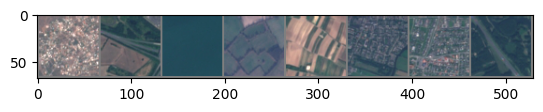

Labels: 73956773


In [21]:
imshow(torchvision.utils.make_grid(images[:8]))
print(f"Labels: {''.join('%d' % labels[j] for j in range(8))}")

## Modelagem - Construção do Modelo de Deep Learning

In [22]:
class IMGNet(nn.Module):
    
    def __init__(self):
        super(IMGNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, 1)
        self.conv2 = nn.Conv2d(64, 128, 3, 1)
        self.conv3 = nn.Conv2d(128, 256, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(215296, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)

        return F.log_softmax(x, dim = 1)

In [23]:
modelo = IMGNet()

In [24]:
print(modelo)

IMGNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=215296, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)


In [25]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [26]:
modelo.to(device)

IMGNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=215296, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)

## Função de Erro

In [27]:
criterion = nn.CrossEntropyLoss()

## Otimizador

In [28]:
optimizer = optim.Adam(modelo.parameters())

## Treinamento do Modelo

In [29]:
num_epochs = 30

In [30]:
testiter = iter(dl_teste)

In [31]:
%%time
print('Treinamento Iniciado')

for epoch in range(num_epochs):
    running_loss = 0.0
    i = 0
    
    for data in (pbar := tqdm(dl_treino)):
        pbar.set_description(f'\n Epoch: {epoch}')
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = modelo(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        total_correct = 0
        total_samples = 0

        if i  % 100 == 0:
            with torch.no_grad():
                test_images, test_labels = next(testiter)
                test_images, test_labels = test_images.to(device), test_labels.to(device)
                test_outputs = modelo(test_images[:8])
                _, predicted = torch.max(test_outputs, 1)
        i += 1
    print(f'Epoch: {epoch}, Loss: {running_loss / (i)}')
print("Treinamento Concluído!")

Treinamento Iniciado


 Epoch: 0: 100%|███████████████████████████████████████████████| 338/338 [01:08<00:00,  4.95it/s]


Epoch: 0, Loss: 1.2065312823600318


 Epoch: 1: 100%|███████████████████████████████████████████████| 338/338 [01:06<00:00,  5.09it/s]


Epoch: 1, Loss: 0.6657820233755564


 Epoch: 2: 100%|███████████████████████████████████████████████| 338/338 [01:07<00:00,  4.99it/s]


Epoch: 2, Loss: 0.4473989161954829


 Epoch: 3: 100%|███████████████████████████████████████████████| 338/338 [01:06<00:00,  5.06it/s]


Epoch: 3, Loss: 0.2862228079748577


 Epoch: 4: 100%|███████████████████████████████████████████████| 338/338 [01:06<00:00,  5.09it/s]


Epoch: 4, Loss: 0.1766595322440362


 Epoch: 5: 100%|███████████████████████████████████████████████| 338/338 [01:07<00:00,  4.97it/s]


Epoch: 5, Loss: 0.14980106742931365


 Epoch: 6: 100%|███████████████████████████████████████████████| 338/338 [01:06<00:00,  5.09it/s]


Epoch: 6, Loss: 0.11042800056059245


 Epoch: 7: 100%|███████████████████████████████████████████████| 338/338 [01:06<00:00,  5.05it/s]


Epoch: 7, Loss: 0.09578512806153289


 Epoch: 8: 100%|███████████████████████████████████████████████| 338/338 [01:06<00:00,  5.09it/s]


Epoch: 8, Loss: 0.07885390716555292


 Epoch: 9: 100%|███████████████████████████████████████████████| 338/338 [01:06<00:00,  5.10it/s]


Epoch: 9, Loss: 0.06744025899681122


 Epoch: 10: 100%|██████████████████████████████████████████████| 338/338 [01:06<00:00,  5.10it/s]


Epoch: 10, Loss: 0.07155225770210451


 Epoch: 11: 100%|██████████████████████████████████████████████| 338/338 [01:06<00:00,  5.08it/s]


Epoch: 11, Loss: 0.053608371748915494


 Epoch: 12: 100%|██████████████████████████████████████████████| 338/338 [01:06<00:00,  5.10it/s]


Epoch: 12, Loss: 0.055332501888855155


 Epoch: 13: 100%|██████████████████████████████████████████████| 338/338 [01:06<00:00,  5.10it/s]


Epoch: 13, Loss: 0.05262058227806567


 Epoch: 14: 100%|██████████████████████████████████████████████| 338/338 [01:06<00:00,  5.11it/s]


Epoch: 14, Loss: 0.05349978681163967


 Epoch: 15: 100%|██████████████████████████████████████████████| 338/338 [01:06<00:00,  5.10it/s]


Epoch: 15, Loss: 0.03540415000608749


 Epoch: 16: 100%|██████████████████████████████████████████████| 338/338 [01:06<00:00,  5.10it/s]


Epoch: 16, Loss: 0.05386311450791297


 Epoch: 17: 100%|██████████████████████████████████████████████| 338/338 [01:06<00:00,  5.10it/s]


Epoch: 17, Loss: 0.047545398453670035


 Epoch: 18: 100%|██████████████████████████████████████████████| 338/338 [01:06<00:00,  5.10it/s]


Epoch: 18, Loss: 0.05628931704010007


 Epoch: 19: 100%|██████████████████████████████████████████████| 338/338 [01:06<00:00,  5.10it/s]


Epoch: 19, Loss: 0.044085064595761524


 Epoch: 20: 100%|██████████████████████████████████████████████| 338/338 [01:06<00:00,  5.10it/s]


Epoch: 20, Loss: 0.06110891872274203


 Epoch: 21: 100%|██████████████████████████████████████████████| 338/338 [01:06<00:00,  5.11it/s]


Epoch: 21, Loss: 0.025256791607345546


 Epoch: 22: 100%|██████████████████████████████████████████████| 338/338 [01:06<00:00,  5.10it/s]


Epoch: 22, Loss: 0.019033206535113034


 Epoch: 23: 100%|██████████████████████████████████████████████| 338/338 [01:06<00:00,  5.11it/s]


Epoch: 23, Loss: 0.024217657843699208


 Epoch: 24: 100%|██████████████████████████████████████████████| 338/338 [01:06<00:00,  5.10it/s]


Epoch: 24, Loss: 0.0333159034436053


 Epoch: 25: 100%|██████████████████████████████████████████████| 338/338 [01:05<00:00,  5.19it/s]


Epoch: 25, Loss: 0.0379517514268267


 Epoch: 26: 100%|██████████████████████████████████████████████| 338/338 [01:05<00:00,  5.19it/s]


Epoch: 26, Loss: 0.02162074589066634


 Epoch: 27: 100%|██████████████████████████████████████████████| 338/338 [01:05<00:00,  5.16it/s]


Epoch: 27, Loss: 0.0279594469146901


 Epoch: 28: 100%|██████████████████████████████████████████████| 338/338 [01:06<00:00,  5.10it/s]


Epoch: 28, Loss: 0.04680223457633463


 Epoch: 29: 100%|██████████████████████████████████████████████| 338/338 [01:06<00:00,  5.10it/s]

Epoch: 29, Loss: 0.033547174497745594
Treinamento Concluído!
CPU times: user 32min 54s, sys: 18.2 s, total: 33min 13s
Wall time: 33min 12s


## Avaliação do Modelo

In [32]:
total_correct = 0
total_samples = 0

In [33]:
modelo.eval()


with torch.no_grad():

    for data in (pbar := tqdm(dl_teste)):
        pbar.set_description(f'Avaliando o Modelo')
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = modelo(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

Avaliando o Modelo: 100%|████████████████████████████████████| 5400/5400 [00:42<00:00, 126.59it/s]


In [35]:
accuracy = total_correct / total_samples
print(accuracy)

0.8237037037037037


## Deploy e Uso do Modelo

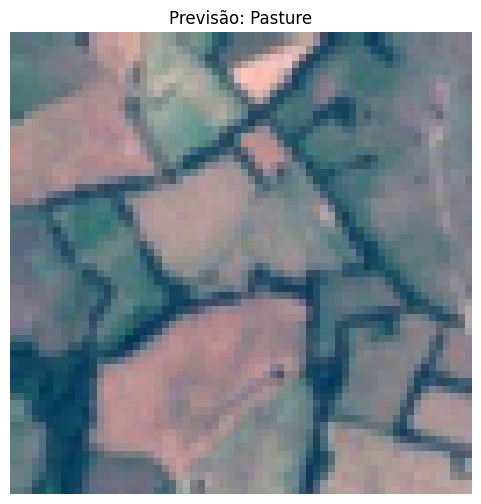

In [39]:
with torch.no_grad():
    data_iter = iter(dl_teste)
    data = next(data_iter)
    inputs, _ = data
    imagem = inputs[0].unsqueeze(0)
    imagem = imagem.to(device)
    outputs = modelo(imagem)
    _, predicted = torch.max(outputs, 1)
    imagem_numpy = imagem.cpu().numpy()[0]
    imagem_numpy = np.transpose(imagem_numpy, (1, 2, 0))
    if imagem_numpy.shape[2] == 1:
        imagem_numpy = np.squeeze(imagem_numpy, axis = 2)
    elif imagem_numpy.shape[2] == 3:
        imagem_numpy = (imagem_numpy - imagem_numpy.min()) / (imagem_numpy.max() - imagem_numpy.min())

    plt.figure(figsize=(6, 6))
    plt.imshow(imagem_numpy)
    plt.title(f'Previsão: {mapeamento[predicted.item()]}')
    plt.axis('off')
    plt.show()